In [46]:
# On importe les bibliothèques utiles pour le projet
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import cv2
# Les functions écrites dans un fichier externe
from functions import *
from collections import namedtuple

from keras_segmentation.models.unet import vgg_unet, resnet50_unet
from keras_segmentation.models.fcn import fcn_8_vgg, fcn_8_resnet50, fcn_32_resnet50
from keras_segmentation.models.segnet import vgg_segnet, resnet50_segnet
from keras import backend as K
from keras.utils import Sequence
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
from numba import cuda
#from keras.utils import multi_gpu_model
from dilatednet import DilatedNet
from models import vgg16unet, build_vgg16_unet

# Importation des images (Train/Validation/Test)

In [6]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

In [7]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [15]:
batch_size = 16
samples = 50000
steps = samples//batch_size
img_height, img_width = 128, 128
classes = 8
filters_n = 64

## Test des modèles VGG16

### Test du modèle créé à partir du modèle pré-entrainé vgg16_U-Net

In [21]:
input_shape = (256, 256, 3)
build_vgg16 = build_vgg16_unet(input_shape)
build_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coeff, 'accuracy', tf.keras.metrics.MeanIoU(num_classes=8)])

In [22]:
hist_build_vgg16 = build_vgg16.fit(train_gen_vgg16, validation_data=val_gen_vgg16, steps_per_epoch=steps, epochs=3, callbacks=callbacks, workers=8)

Epoch 1/3
6250/6250 [==============================] - 2068s 329ms/step - loss: 0.2924 - dice_coeff: 0.0586 - accuracy: 0.1486 - mean_io_u: 0.4896 - val_loss: 0.2872 - val_dice_coeff: 0.0485 - val_accuracy: 0.1650 - val_mean_io_u: 0.4900
Epoch 2/3
6250/6250 [==============================] - 2064s 330ms/step - loss: 0.2994 - dice_coeff: 0.0506 - accuracy: 0.0960 - mean_io_u: 0.4896 - val_loss: 0.2933 - val_dice_coeff: 0.0541 - val_accuracy: 0.2130 - val_mean_io_u: 0.4895
Epoch 3/3
6250/6250 [==============================] - 2050s 328ms/step - loss: 0.2890 - dice_coeff: 0.0541 - accuracy: 0.0746 - mean_io_u: 0.4896 - val_loss: 0.3007 - val_dice_coeff: 0.0562 - val_accuracy: 0.0659 - val_mean_io_u: 0.4892


In [64]:
# Charger le modèle
model = tf.keras.models.load_model('best_model', custom_objects={'dice_coeff': dice_coeff})

In [73]:
img_path = 'datas/images/test/berlin/berlin_000000_000019_leftImg8bit.png'
img = image.load_img(img_path, target_size=(256, 256)) 
# Convertir l'image en tableau NumPy et prétraiter
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour correspondre à la forme attendue par le modèle
#img_array = img_array / 255.0  # Normaliser les valeurs des pixels si nécessaire

In [74]:
predictions = model.predict(img_array)

1/1 [==============================] - 0s 20ms/step


In [84]:
predictions*255

array([[[[3.33117874e-04, 2.49747818e+02, 3.85630399e-01, ...,
          3.84700489e+00, 1.34907097e-01, 4.60554242e-01],
         [1.19670236e-04, 2.47634537e+02, 2.41517704e-02, ...,
          1.01379771e-03, 2.68156373e-06, 5.93778431e-01],
         [2.88964096e-19, 2.55000000e+02, 6.34107877e-09, ...,
          2.02461388e-16, 6.69742040e-14, 1.18033912e-08],
         ...,
         [1.97796035e-04, 2.54808533e+02, 8.95208344e-02, ...,
          9.40329337e-05, 2.47932062e-03, 9.71442908e-02],
         [6.02403522e-01, 2.33310501e+02, 1.05537786e+01, ...,
          2.80297607e-01, 1.30744469e+00, 7.24464989e+00],
         [6.21597329e-10, 2.54999512e+02, 1.88886133e-05, ...,
          3.16294754e-04, 1.14275033e-04, 1.27713174e-05]],

        [[2.55000000e+02, 6.19081815e-29, 3.10172847e-27, ...,
          0.00000000e+00, 3.14698934e-15, 2.03659389e-19],
         [2.55000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        

In [90]:
predictions[0][0][0]

array([1.3063446e-06, 9.7940320e-01, 1.5122761e-03, 1.6293925e-05,
       1.6455726e-03, 1.5086294e-02, 5.2904745e-04, 1.8060950e-03],
      dtype=float32)

In [47]:
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

In [76]:
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [77]:
couleur = {'void': [0, 1, 2, 3, 4, 5, 6],
             'flat': [7, 8, 9, 10],
             'construction': [11, 12, 13, 14, 15, 16],
             'object': [17, 18, 19, 20],
             'nature': [21, 22],
             'sky': [23],
             'human': [24, 25],
             'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}
couleur_id = {'void': (0),
              'flat': (1),
             'construction': (2),
             'object': (3),
             'nature': (4),
             'sky': (5),
             'human': (6),
             'vehicle': (7)}
cat_couleur = {}
for label in labels :
    category = label.category
    if category in cat_couleur :
        cat_couleur[category].append(label)
    else :
        cat_couleur[category] = label
    

AttributeError: 'Label' object has no attribute 'append'

In [59]:
predictions.shape

(1, 16384, 8)

In [63]:
predictions = predictions.reshape(1,256,256,8)
predictions

ValueError: cannot reshape array of size 131072 into shape (1,256,256,8)

In [85]:
predictions.shape
prediction_image = np.squeeze(predictions*255)
prediction_image.shape

(256, 256, 8)

In [86]:
seg_img = np.zeros((256,256,3),dtype=np.uint8)
for id in range(prediction_image.shape[2]) :
    couleur_seg = cat_couleur.get(id,(0,0,0))
    for j in range(3) :
        seg_img[:,:,j] += (prediction_image[:,:,id]*couleur_seg[j]).astype(np.uint8)

In [87]:
seg_img.shape

(256, 256, 3)

In [88]:
seg_img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

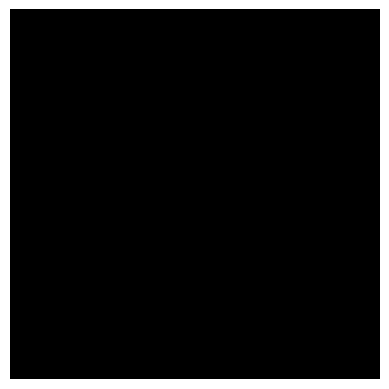

In [89]:
plt.imshow(seg_img)
plt.axis('off')  # Pour ne pas afficher les axes
plt.show()